# Loads libraries and functions

In [3]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

In [2]:
source("load_libraries.R")

Warning message in is.na(x[[i]]):
“is.na() applied to non-(list or vector) of type 'environment'”Warning message in rsqlite_fetch(res@ptr, n = n):
“Don't need to call dbFetch() for statements, only for queries”

*
*  Package WGCNA 1.63 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=4
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=4
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*


Allowing multi-threading with up to 4 threads.
[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."
[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."
[1] "preparing gene to GO mapping data..."
[1] "prepar

In [3]:
source("functions.R")

# Get the data

In [4]:
# Load the count table
#counts = read.table(system("get -i 1184 ", intern=T), sep="\t", header = 1, row.names=1)
counts = read.table("../data/counts.tabular", sep="\t", header = 1, row.names=1)
gene_length = read.table("../data/gene_length.tabular", h = F, row.names = 1)
gene_length = gene_length[rownames(counts),]
names(gene_length) = rownames(counts)

In [5]:
# Map between Entrez Gene Identifiers and Gene Names (and description) 
eg2name = get_list(org.Mm.egGENENAME)
# Map between Gene Symbols and Entrez Gene Identifiers
symbol2eg = get_list(org.Mm.egSYMBOL2EG)
# Map between RefSeq and Entrez Gene Identifiers
refseq2eg = get_list(org.Mm.egREFSEQ2EG)
# Map between Gene Symbols and Gene Names (and description)
symbol2name = sapply(names(symbol2eg), function(x) return(eg2name[symbol2eg[[x]]]))
head(symbol2name)
# Map between Entrez Gene Identifiers and KEGG pathways
eg2kegg=as.list(org.Mm.egPATH)

$Pzp
$Pzp$`11287`
[1] "pregnancy zone protein"


$Aanat
$Aanat$`11298`
[1] "arylalkylamine N-acetyltransferase"


$Aatk
$Aatk$`11302`
[1] "apoptosis-associated tyrosine kinase"


$Abca1
$Abca1$`11303`
[1] "ATP-binding cassette, sub-family A (ABC1), member 1"


$Abca4
$Abca4$`11304`
[1] "ATP-binding cassette, sub-family A (ABC1), member 4"


$Abca2
$Abca2$`11305`
[1] "ATP-binding cassette, sub-family A (ABC1), member 2"

In [6]:
# get refseq ids for genes
refseq = sapply(rownames(counts), function(x) return(symbol2eg[[x]])) 
length(refseq[sapply(refseq, is.null)])
to_change = names(refseq[sapply(refseq, is.null)])

[1] 312

In [7]:
changes = sapply(to_change, search_name)

In [8]:
doubled = sapply(names(changes), function(x) return(length(changes[[x]])>1))
single = changes[!doubled]
duplicated = single %in% rownames(counts)
non_duplicated = single[!duplicated]
duplicated_2 = duplicated(non_duplicated)
replacements = non_duplicated[!duplicated_2]

In [9]:
# Fix name of the some genes (identified if no Entrez id found for them and with new names found)
replacements = unlist(replacements)
#rownames(counts)[rownames(counts) == "1700112E06Rik"] = "Lrmda"
new_names = rownames(counts)
names(new_names) = rownames(counts)
new_names[names(replacements)] = replacements
head(new_names)

0610005C13Rik   0610007P14Rik   0610009B22Rik   0610009L18Rik   0610009O20Rik 
"0610005C13Rik" "0610007P14Rik" "0610009B22Rik" "0610009L18Rik" "0610009O20Rik" 
  0610010B08Rik 
"0610010B08Rik"

In [10]:
rownames(counts) = new_names
names(gene_length) = new_names
head(counts)
head(gene_length)

,GF_104w_F_1_2,GF_104w_F_2_2,GF_104w_F_3_2,GF_104w_M_1_2,GF_104w_M_2_2,GF_52w_M_1_2,GF_52w_M_2_2,GF_52w_M_3_2,GF_52w_M_4_2,GF_8w_M_1_2,⋯,SPF_8w_F_4_2,SPF_8w_F_5_2,GF_8w_F_1_2,GF_8w_F_2_2,GF_8w_F_3_2,GF_8w_F_4_2,GF_8w_F_5_2,GF_104w_M_3_2,GF_104w_M_5_2,GF_104w_M_4_2
0610005C13Rik,0,0,0,2,2,1,5,5,10,7,⋯,2,0,17,0,2,5,0,1,1,1
0610007P14Rik,954,704,999,1002,1577,604,537,459,1021,499,⋯,698,891,837,627,605,563,631,394,570,496
0610009B22Rik,1122,1098,1296,1385,2475,1234,887,907,1214,784,⋯,996,1346,969,938,1128,911,853,551,772,522
0610009L18Rik,31,34,20,23,61,38,27,20,6,51,⋯,79,67,45,18,11,43,19,20,22,26
0610009O20Rik,239,262,292,256,432,356,354,353,428,298,⋯,175,172,216,146,268,289,210,269,351,263
0610010B08Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


0610005C13Rik 0610007P14Rik 0610009B22Rik 0610009L18Rik 0610009O20Rik 
         1122          1185           795           619          2404 
0610010B08Rik 
        27229

In [11]:
refseq_check = sapply(rownames(counts), function(x) return(symbol2eg[[x]])) 
length(refseq[sapply(refseq_check, is.null)])

[1] 38

In [12]:
# Remove the columns with spurious data
to_remove = c("SPF_8w_F_2_2")
counts = counts[,!names(counts) %in% to_remove]

In [181]:
file_desc = read.csv("../data/file_description.csv", row.names = 1)
file_desc = head(file_desc,-6)
file_desc = file_desc[!rownames(file_desc) %in% c("SPF_8w_F_2"), ]
file_desc$"Lane" = gsub(" & ", "_",file_desc$"Lane")
file_desc$"Lane" = gsub(" ", "1",file_desc$"Lane")
head(file_desc)

,Sample.name.prefix,Galaxy.ID,Group,Age,Gender,Replicate,Project.id,Lane,Name.in.project,X..Reads
GF_52w_M_1,GF_52w_M,NA,GF,52w,M,1,Project_148_1,2,Sample_Mg_GF1_old,"35,713,942.00"
GF_8w_M_1,GF_8w_M,NA,GF,8w,M,1,Project_148_1,2,Sample_Mg_GF1_young,"25,919,398.00"
GF_52w_M_2,GF_52w_M,NA,GF,52w,M,2,Project_148_2,2,Sample_Mg_GF2_old,"29,752,263.00"
GF_8w_M_2,GF_8w_M,NA,GF,8w,M,2,Project_148_2,2,Sample_Mg_GF2_young,"24,133,081.00"
GF_52w_M_3,GF_52w_M,NA,GF,52w,M,3,Project_148_1,3,Sample_Mg_GF3_old,"26,395,568.00"
GF_8w_M_3,GF_8w_M,NA,GF,8w,M,3,Project_148_1,1,Sample_Mg_GF3_young,"33,992,780.00"


In [182]:
# Extract the metadata
metadata = t(sapply(sapply(colnames(counts), strsplit, split = "_"), unlist))
short_names = paste(metadata[,1], metadata[,2], metadata[,3], metadata[,4], sep ="_")
names(short_names) = rownames(metadata)
metadata = metadata[,-5]
colnames(metadata) = c("type", "age", "gender", "replicate")
metadata = as.data.frame(metadata)
metadata$replicate <- NULL
metadata$project = paste(unlist(file_desc[short_names,'Project.id']))
metadata

,type,age,gender,project
GF_104w_F_1_2,GF,104w,F,Project_S264
GF_104w_F_2_2,GF,104w,F,Project_S264
GF_104w_F_3_2,GF,104w,F,Project_S264
GF_104w_M_1_2,GF,104w,M,Project_S264
GF_104w_M_2_2,GF,104w,M,Project_S264
GF_52w_M_1_2,GF,52w,M,Project_148_1
GF_52w_M_2_2,GF,52w,M,Project_148_2
GF_52w_M_3_2,GF,52w,M,Project_148_1
GF_52w_M_4_2,GF,52w,M,Project_148_2
GF_8w_M_1_2,GF,8w,M,Project_148_1


In [14]:
save(gene_length, file="../results/dge/gene_length.RData")

# DGE analysis construction

## Testing how the complexification of the model explain the data

In [15]:
complexif_stats = data.frame(matrix(0, nrow=0, ncol=4))
colnames(complexif_stats) = c("Design", "Reduced", "Tested", "Genes with LRT padj < 0.05")

In [163]:
# Design: project
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ project)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("project", "1", "project", get_sign_padj(LRT_res), 0)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 241 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [16]:
# Design: gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender", "1", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 688 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [17]:
# Design: type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type", "1", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 701 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [18]:
# Design: age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age", "1", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 666 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [19]:
# Design: gender + type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type)
dge = DESeq(dds, test="LRT", reduced = ~ gender)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type", "gender", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 756 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [20]:
# Design: gender + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + age", "gender", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 552 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [21]:
# Design: type + gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + gender)
dge = DESeq(dds, test="LRT", reduced = ~ type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + gender", "type", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 756 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [22]:
# Design: type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + age)
dge = DESeq(dds, test="LRT", reduced = ~ type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + age", "type", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 553 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [23]:
# Design: age + gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age + gender)
dge = DESeq(dds, test="LRT", reduced = ~ age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age + gender", "age", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 552 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [24]:
# Design: age + type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age + type)
dge = DESeq(dds, test="LRT", reduced = ~ age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age + type", "age", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 553 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [25]:
# Design: gender + type + gender:type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + gender:type)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + gender:type", "gender + type", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 574 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [26]:
# Design: gender + age + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + age + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + age + gender:age", "gender + age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 334 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [27]:
# Design: type + age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + age + type:age", "type + age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 342 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [28]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "gender + type", "age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 339 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [29]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "gender + age", "type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 339 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [30]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "type + age", "gender", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 339 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [31]:
# Design: gender + type + age + gender:type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type", "gender + type + age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 291 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [32]:
# Design: gender + type + age + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age", "gender + type + age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 211 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [33]:
# Design: gender + type + age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + type:age", "gender + type + age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 221 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [34]:
# Design: gender + type + age + gender:type + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age", "gender + type + age + gender:type", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 211 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [35]:
# Design: gender + type + age + gender:type + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age", "gender + type + age + gender:age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 211 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [36]:
# Design: gender + type + age + gender:type + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + type:age", "gender + type + age + gender:type", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 210 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [37]:
# Design: gender + type + age + gender:type + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + type:age", "gender + type + age + type:age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 210 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [38]:
# Design: gender + type + age + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age + type:age", "gender + type + age + gender:age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 193 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [39]:
# Design: gender + type + age + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age + type:age", "gender + type + age + type:age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 193 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [40]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:type + gender:age", "type:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 168 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT


In [41]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:type + type:age", "gender:age", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 168 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT


In [42]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:age + type:age", "gender:type", get_sign_padj(LRT_res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 168 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT


In [164]:
complexif_stats$"% genes with LRT padj < 0.05" = 100 * strtoi(complexif_stats$"Genes with LRT padj < 0.05") / dim(LRT_res)[1]
complexif_stats

Design,Reduced,Tested,Genes with LRT padj < 0.05,% genes with LRT padj < 0.05
gender,1,gender,3367,13.7873142
type,1,type,2231,9.1355800
age,1,age,3559,14.5735228
gender + type,gender,type,2132,8.7301912
gender + age,gender,age,4696,19.2293518
type + gender,type,gender,3219,13.1812784
type + age,type,age,3773,15.4498178
age + gender,age,gender,4288,17.5586585
age + type,age,type,2456,10.0569182
gender + type + gender:type,gender + type,gender:type,50,0.2047418


Factor | Explanation (Percentage of genes with LRT padj < 0.05)
--- | --- | ---
gender | 13.2% - 17.6%
type | 8.7% - 10.4%
age | 14.6% - 20.3%
gender:type | 0.13% - 0.32%
gender:age | 8.4% - 9.72%
type:age | 2.02% - 2.87%

## Construct the full model

In [188]:
mm = model.matrix(~ gender + type + age + gender:age + gender:type + type:age + project, metadata)
mm

,(Intercept),genderM,typeSPF,age52w,age8w,projectProject_148_2,projectProject_S174,projectProject_S178,projectProject_S198,projectProject_S225,projectProject_S264,projectS288,genderM:age52w,genderM:age8w,genderM:typeSPF,typeSPF:age52w,typeSPF:age8w
GF_104w_F_1_2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
GF_104w_F_2_2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
GF_104w_F_3_2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
GF_104w_M_1_2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
GF_104w_M_2_2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
GF_52w_M_1_2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
GF_52w_M_2_2,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
GF_52w_M_3_2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
GF_52w_M_4_2,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
GF_8w_M_1_2,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [183]:
# Construct DESeqDataSet
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + gender:type + type:age)
# Organize levels of the factors (8w being the reference)
dds$age = relevel(dds$age, ref="8w")
dds$type = relevel(dds$type, ref="SPF")
dds$gender = relevel(dds$gender, ref="F")
# Differential expression analysis
dge = DESeq(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

ERROR: Error in checkFullRank(modelMatrix): the model matrix is not full rank, so the model cannot be fit as specified.
  One or more variables or interaction terms in the design formula are linear
  combinations of the others and must be removed.

  Please read the vignette section 'Model matrix not full rank':

  vignette('DESeq2')


In [52]:
resultsNames(dge)

[1] "Intercept"       "gender_M_vs_F"   "type_GF_vs_SPF"  "age_104w_vs_8w" 
 [5] "age_52w_vs_8w"   "genderM.age104w" "genderM.age52w"  "genderM.typeGF" 
 [9] "typeGF.age104w"  "typeGF.age52w"

Info | M/F | GF/SPF | 104w/8w | 52w/8w | M.104w | M.52w | M.GF | GF.104w | GF.52w
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
M vs F (SPF, 8w) | 1 | | | | | | | |
M vs F (GF, 8w) | 1 | | | | | | 1 | |
M vs F (SPF, 52w) | 1 | | | | | 1 | | |
M vs F (GF, 52w) | 1 | | | | | 1 | 1 | | 1?
M vs F (SPF, 104w) | 1 | | | | 1 | | | |
M vs F (GF, 104w) | 1 | | | | 1 | | 1 | 1? |
M vs F (SPF) | 1 | | | | 1/3 | 1/3 | | |
M vs F (GF) | 1 | | | | 1/3 | 1/3 | | 1/3? | 1/3?
M vs F (8w) | 1 | | | | | | 1/2 | |
M vs F (52w) | 1 | | | | | 1 | 1/2 | | 1/2?
M vs F (104w) | 1 | | | | 1 | | 1/2 | 1/2? |
M vs F | 1 | | | | 1/3 | 1/3 | 1/2 | 1/3? | 1/3?
GF vs SPF (F, 8w) | | 1 | | | | | | |
GF vs SPF (M, 8w) | | 1 | | | | | 1 | |
GF vs SPF (F, 52w) | | 1 | | | | | | | 1
GF vs SPF (M, 52w) | | 1 | | | | 1? | 1 | | 1
GF vs SPF (F, 104w) | | 1 | | | | | | 1 |
GF vs SPF (M, 104w) | | 1 | | | 1? | | 1 | 1 |
GF vs SPF (F) | | 1 | | | | | | 1/3 | 1/3
GF vs SPF (M) | | 1 | | | 1/3? | 1/3? | 1 | 1/3 | 1/3
GF vs SPF (8w) | | 1 | | | | | 1/2 | |
GF vs SPF (52w) | | 1 | | | | 1/2? | 1/2 | | 1
GF vs SPF (104w) | | 1 | | | 1/2? | | 1/2 | 1 |
GF vs SPF | | 1 | | | 1/3? | 1/3? | 1/2 | 1/3 | 1/3
52w vs 8w (F, SPF) | | | | 1 | | | | |
52w vs 8w (F, GF) | | | | 1 | | | | | 1
52w vs 8w (M, SPF) | | | | 1 | | 1 | | |
52w vs 8w (M, GF) | | | | 1 | | 1 | 1? | | 1
52w vs 8w (F) | | | | 1 | | | | | 1/2
52w vs 8w (M) | | | | 1 | | 1 | 1/2? | | 1/2
52w vs 8w (SPF) | | | | 1 | | 1/2 | | |
52w vs 8w (GF) | | | | 1 | | 1/2 | 1/2? | | 1
52w vs 8w | | | | 1 | | 1/2 | 1/2? | | 1/2
104w vs 8w (F, SPF) | | | 1 | | | | | |
104w vs 8w (F, GF) | | | 1 | | | | | 1 |
104w vs 8w (M, SPF) | | | 1 | | 1 | | | |
104w vs 8w (M, GF) | | | 1 | | 1 | | 1? | 1 |
104w vs 8w (F) | | | 1 | | | | | 1/2 |
104w vs 8w (M) | | | 1 | | 1 | | 1/2? | 1/2 |
104w vs 8w (SPF) | | | 1 | | 1/2 | | | |
104w vs 8w (GF) | | | 1 | | 1/2 | | 1/2? | 1 |
104w vs 8w | | | 1 | | 1/2 | | 1/2? | 1/2 |
104w vs 52w (F, SPF) | | | 1 | -1 | | | | |
104w vs 52w (F, GF) | | | 1 | -1 | | | | 1 | -1
104w vs 52w (M, SPF) | | | 1 | -1 | 1 | -1 | | |
104w vs 52w (M, GF) | | | 1 | -1 | 1 | -1 | | 1 | -1
104w vs 52w (F) | | | 1 | -1 | | | | 1/2 | -1/2
104w vs 52w (M) | | | 1 | -1 | 1 | -1 | | 1/2 | -1/2
104w vs 52w (SPF) | | | 1 | -1 | 1/2 | -1/2 | | |
104w vs 52w (GF) | | | 1 | -1 | 1/2 | -1/2 | | |
104w vs 52w | | | 1 | -1 | 1/2 | -1/2 | | 1/2 | -1/2

In [82]:
norm_counts = counts(dge,normalized=TRUE)
head(norm_counts)

,GF_104w_F_1_2,GF_104w_F_2_2,GF_104w_F_3_2,GF_104w_M_1_2,GF_104w_M_2_2,GF_52w_M_1_2,GF_52w_M_2_2,GF_52w_M_3_2,GF_52w_M_4_2,GF_8w_M_1_2,⋯,SPF_8w_F_4_2,SPF_8w_F_5_2,GF_8w_F_1_2,GF_8w_F_2_2,GF_8w_F_3_2,GF_8w_F_4_2,GF_8w_F_5_2,GF_104w_M_3_2,GF_104w_M_5_2,GF_104w_M_4_2
0610005C13Rik,0.00000,0.00000,0.00000,1.747854,1.244311,0.8338695,4.892544,5.547012,7.158344,8.384882,⋯,2.57208,0.00000,18.04370,0.00000,2.001891,5.212621,0.00000,1.243886,1.039189,1.495931
0610007P14Rik,857.59757,740.81613,899.06639,875.674692,981.138840,503.6571924,525.459208,509.215656,730.866890,597.722277,⋯,897.65596,947.91171,888.38701,674.46562,605.571925,586.941079,799.60448,490.090915,592.337898,741.981645
0610009B22Rik,1008.62104,1155.42062,1166.35639,1210.388671,1539.834260,1028.9949924,867.937277,1006.227887,869.022923,939.106744,⋯,1280.89590,1431.97437,1028.49105,1009.00917,1129.066334,949.739473,1080.92333,685.380950,802.254135,780.875844
0610009L18Rik,27.86743,35.77805,17.99933,20.100317,37.951471,31.6870419,26.419737,22.188046,4.295006,61.089852,⋯,101.59716,71.27956,47.76274,19.36265,11.010399,44.828537,24.07684,24.877711,22.862164,38.894199
0610009O20Rik,214.84887,275.70146,262.79017,223.725271,268.771071,296.8575505,346.392104,391.619012,306.377109,356.956390,⋯,225.05701,182.98632,229.26116,157.05260,268.253349,301.289471,266.11243,334.605219,364.755442,393.429783
0610010B08Rik,0.00000,0.00000,0.00000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.000000,⋯,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [210]:
head(counts(dge))

,GF_104w_F_1_2,GF_104w_F_2_2,GF_104w_F_3_2,GF_104w_M_1_2,GF_104w_M_2_2,GF_52w_M_1_2,GF_52w_M_2_2,GF_52w_M_3_2,GF_52w_M_4_2,GF_8w_M_1_2,⋯,SPF_8w_F_4_2,SPF_8w_F_5_2,GF_8w_F_1_2,GF_8w_F_2_2,GF_8w_F_3_2,GF_8w_F_4_2,GF_8w_F_5_2,GF_104w_M_3_2,GF_104w_M_5_2,GF_104w_M_4_2
0610005C13Rik,0,0,0,2,2,1,5,5,10,7,⋯,2,0,17,0,2,5,0,1,1,1
0610007P14Rik,954,704,999,1002,1577,604,537,459,1021,499,⋯,698,891,837,627,605,563,631,394,570,496
0610009B22Rik,1122,1098,1296,1385,2475,1234,887,907,1214,784,⋯,996,1346,969,938,1128,911,853,551,772,522
0610009L18Rik,31,34,20,23,61,38,27,20,6,51,⋯,79,67,45,18,11,43,19,20,22,26
0610009O20Rik,239,262,292,256,432,356,354,353,428,298,⋯,175,172,216,146,268,289,210,269,351,263
0610010B08Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [211]:
head(counts)

,GF_104w_F_1_2,GF_104w_F_2_2,GF_104w_F_3_2,GF_104w_M_1_2,GF_104w_M_2_2,GF_52w_M_1_2,GF_52w_M_2_2,GF_52w_M_3_2,GF_52w_M_4_2,GF_8w_M_1_2,⋯,SPF_8w_F_4_2,SPF_8w_F_5_2,GF_8w_F_1_2,GF_8w_F_2_2,GF_8w_F_3_2,GF_8w_F_4_2,GF_8w_F_5_2,GF_104w_M_3_2,GF_104w_M_5_2,GF_104w_M_4_2
0610005C13Rik,0,0,0,2,2,1,5,5,10,7,⋯,2,0,17,0,2,5,0,1,1,1
0610007P14Rik,954,704,999,1002,1577,604,537,459,1021,499,⋯,698,891,837,627,605,563,631,394,570,496
0610009B22Rik,1122,1098,1296,1385,2475,1234,887,907,1214,784,⋯,996,1346,969,938,1128,911,853,551,772,522
0610009L18Rik,31,34,20,23,61,38,27,20,6,51,⋯,79,67,45,18,11,43,19,20,22,26
0610009O20Rik,239,262,292,256,432,356,354,353,428,298,⋯,175,172,216,146,268,289,210,269,351,263
0610010B08Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Check any potential batch effect

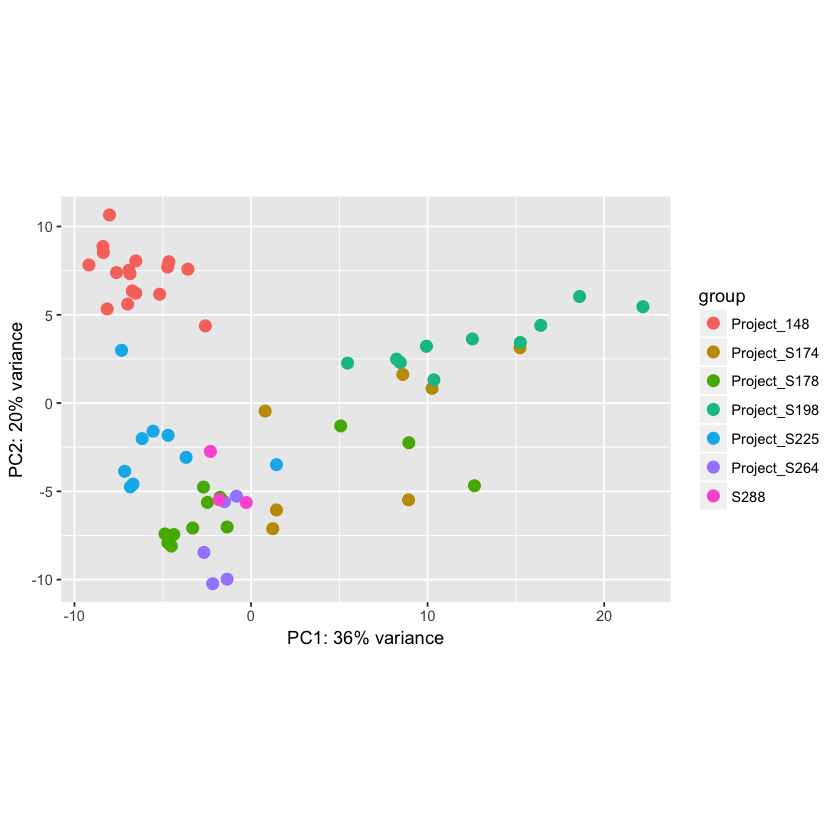

In [165]:
rld <- rlog(dds)
plotPCA(rld, intgroup = "project")

# Save files

In [130]:
save(dge, file = "../results/dge/dge.RData")
save(norm_counts, file="../results/dge/norm_counts.RData")
save(metadata, file="../results/dge/metadata.RData")

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
Warning message:
“Bioconductor version 3.4 is too old for R version 3.4.3; see
  https://bioconductor.org/install/#troubleshoot-biocinstaller”BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘sva’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'BH', 'bindr', 'bindrcpp', 'bit', 'broom', 'callr', 'car',
  'caret', 'caTools', 'clipr', 'cluster', 'curl', 'CVST', 'data.table', 'DBI',
  'dbplyr', 'ddalpha', 'devtools', 'digest', 'dplyr', 'DRR', 'evaluate',
  'fastcluster', 'forcats', 'foreign', 'Formula', 'fpc', 'futile.options',
  'ggplot2', 'gistr', 'git2r', 'glmnet', 'glue', 'gtools', 'haven', 'hexbin',
  'highr', 'hms', 'htmlTable', 'htmlwidgets', 'httpuv', 'IRdisplay',
  'iterators', 'kernlab', 'knitr', 'lambda.r', 'lava', 'lme4', 'lubridate',
  'maps', 'MASS', 'Matrix', 'mclust', 'mgcv', 'modelr'